In [15]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skdemo
%matplotlib inline

# Histogram Processing

Histograms are a quick way to get a feel for the global statistics of the image intensity. For example, they can tell you how to adjust the contrast of an image.

### Histograms of images

For this section, we're going to use a custom plotting function that adds a few tweaks to pretty-it-up:
* Plot the image next to the histogram
* Plot each RGB channel separately
* Automatically flatten channels
* Select reasonable bins based on the image's `dtype`

In [16]:
skdemo.imshow_with_histogram?

Signature: skdemo.imshow_with_histogram(image, **kwargs)
Docstring:
Plot an image side-by-side with its histogram.

- Plot the image next to the histogram
- Plot each RGB channel separately (if input is color)
- Automatically flatten channels
- Select reasonable bins based on the image's dtype

See `plot_histogram` for information on how the histogram is plotted.
File:      ~/Dropbox/EE5806/Lecture03_Spatial_Enhancement/demo03/skdemo/_skdemo.py
Type:      function


Using this function, let's look at the histogram of a grayscale image:

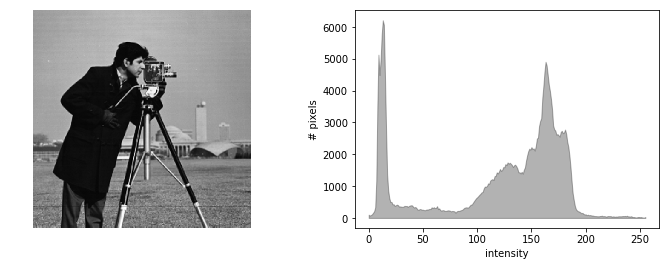

In [17]:
from skimage import data
image = data.camera()
skdemo.imshow_with_histogram(image);

An image histogram shows the number of pixels at each intensity value (or range of intensity values, if values are binned). Low-intensity values are closer to black, and high-intensity values are closer to white.

Notice that there's a large peak at an intensity of about 10: This peak corresponds with the man's nearly black coat. The peak around the middle of the histogram is due to the predominantly gray tone of the image.

Now let's look at our color image:

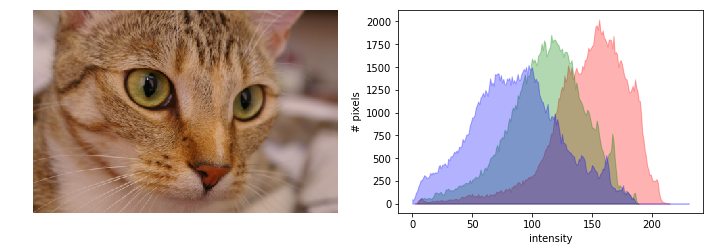

In [18]:
cat = data.chelsea()
skdemo.imshow_with_histogram(cat);

As you can see, the intensity for each RGB channel is plotted separately. Unlike the previous histogram, these histograms almost look like Gaussian distributions that are shifted. This reflects the fact that intensity changes are relatively gradual in this picture: There aren't very many uniform instensity regions in this image.

**Note:** While RGB histograms are pretty, they are often not very intuitive or useful, since a high red value is very different when combined with *low* green/blue values (the result will tend toward red) vs *high* green and blue values (the result will tend toward white).

## Gamma and Log Contrast Adjustment

This example adjusts image contrast by performing a Gamma and a Logarithmic correction on the input image.

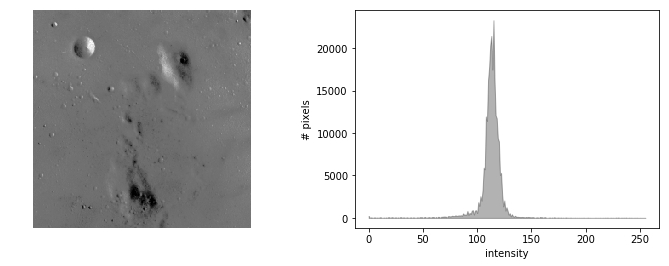

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, img_as_float
from skimage import exposure

# Load an example image
image = data.moon()
skdemo.imshow_with_histogram(image);

This is a low contrast image of the moom surface.

To enhance the image for better visulaization, we can apply Gamma and Lograithmic corrections on this image.

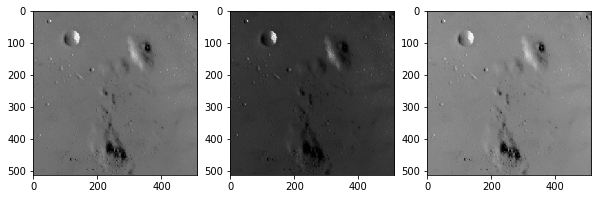

In [20]:
# Gamma
gamma_corrected = exposure.adjust_gamma(image, 2)

# Logarithmic
logarithmic_corrected = exposure.adjust_log(image, 1)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(10, 5))
ax0.imshow(image, cmap='gray')
ax1.imshow(gamma_corrected, cmap='gray');
ax2.imshow(logarithmic_corrected, cmap='gray');

## Histograms and Contrast

Enhancing the contrast of an image allow us to more easily identify features in an image, both by eye and by detection algorithms.

Let's take another look at the gray-scale image from earlier:

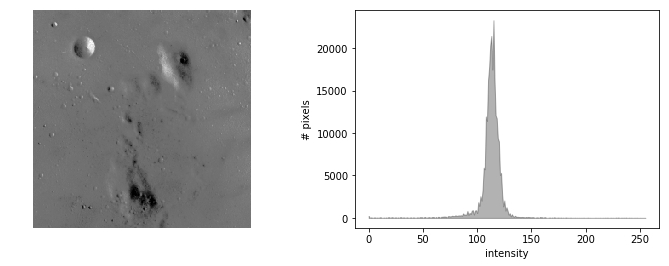

In [21]:
image = data.moon()
skdemo.imshow_with_histogram(image);

Notice the intensity values at the bottom. Since the image has a `dtype` of `uint8`, the values go from 0 to 255. Though you can see some pixels tail off toward 0 and 255, you can clearly see in the histogram, and in the image, that we're not using both low-intensity and high-intensity limits very well.

Based on the histogram values, you might want to take all the pixels values that are more than about 140 in the image, and make them pure white (i.e. an intensity of 255). While we're at it, values less than about 90 can be set to pure black (i.e. 0). We can do this easily using `rescale_intensity`, from the `exposure` subpackage.

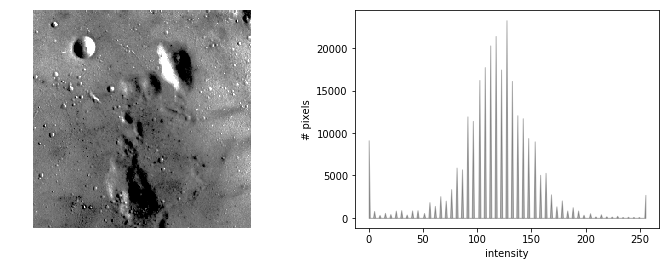

In [22]:
from skimage import exposure
high_contrast = exposure.rescale_intensity(image, in_range=(90, 140))

skdemo.imshow_with_histogram(high_contrast);

The contrast is visibly higher in the image, and the histogram is noticeably stretched. The sharp peak on the right is due to all the pixels greater than 140 (in the original image) that were piled into a single bin (i.e. 255).

In [23]:
exposure.rescale_intensity?

Signature: exposure.rescale_intensity(image, in_range='image', out_range='dtype')
Docstring:
Return image after stretching or shrinking its intensity levels.

The desired intensity range of the input and output, `in_range` and
`out_range` respectively, are used to stretch or shrink the intensity range
of the input image. See examples below.

Parameters
----------
image : array
    Image array.
in_range, out_range : str or 2-tuple
    Min and max intensity values of input and output image.
    The possible values for this parameter are enumerated below.

    'image'
        Use image min/max as the intensity range.
    'dtype'
        Use min/max of the image's dtype as the intensity range.
    dtype-name
        Use intensity range based on desired `dtype`. Must be valid key
        in `DTYPE_RANGE`.
    2-tuple
        Use `range_values` as explicit min/max intensities.

Returns
-------
out : array
    Image array after rescaling its intensity. This image is the same dtype
    as the 

Parameters for `rescale_intensity`:
* `in_range`: The min and max intensity values desired in the input image. Values below/above these limits will be clipped.
* `out_range`: The min and max intensity values of the output image. Pixels matching the limits from `in_range` will be rescaled to these limits. Everything in between gets linearly interpolated.

## Histogram Equalization

In the previous example, the grayscale values (90, 140) were set to (0, 255), and everything in between was linearly interpolated. There are other strategies for contrast enhancement that try to be a bit more intelligent---notably histogram equalization.

Let's first look at the cumulative distribution function (CDF) of the image intensities.

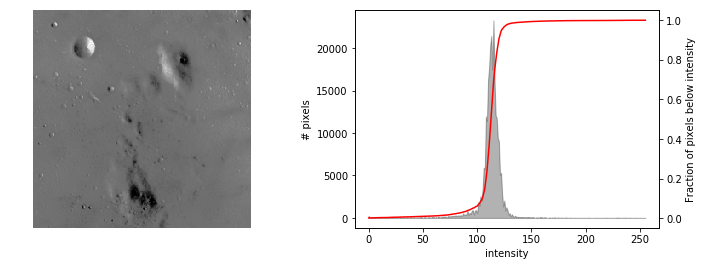

In [24]:
ax_image, ax_hist = skdemo.imshow_with_histogram(image)
skdemo.plot_cdf(image, ax=ax_hist.twinx())

For each intensity value, the CDF gives the fraction of pixels *below* that intensity value.

One measure of contrast is how evenly distributed intensity values are: The dark coat might contrast sharply with the background, but the tight distribution of pixels in the dark coat mean that details in the coat are hidden.

To enhance contrast, we could *spread out intensities* that are tightly distributed and *combine intensities* which are used by only a few pixels.

This redistribution is exactly what histogram equalization does. And the CDF is important because a perfectly uniform distribution gives a CDF that's a straight line. We can use `equalize_hist` from the `exposure` package to produce an equalized image:

In [25]:
equalized = exposure.equalize_hist(image)

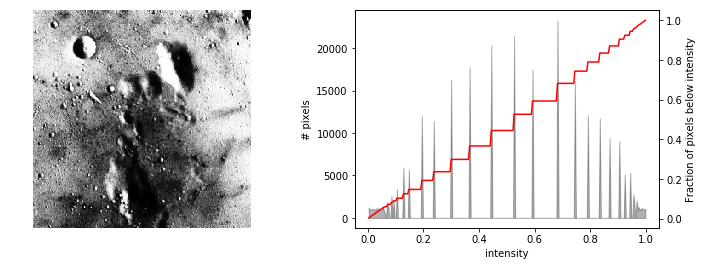

In [26]:
ax_image, ax_hist = skdemo.imshow_with_histogram(equalized)
skdemo.plot_cdf(equalized, ax=ax_hist.twinx())

The tightly distributed dark-pixels in the coat have been spread out, which reveals many details in the coat that were missed earlier. As promised, this more even distribution produces a CDF that approximates a straight line.

Notice that the image intensities switch from 0--255 to 0.0--1.0:

In [27]:
equalized.dtype

dtype('float64')

Functions in `scikit-image` allow any data-type as an input, but the output data-type may change depending on the algorithm. While `uint8` is really efficient in terms of storage, we'll see in the next section that computations using `uint8` images can be problematic in certain cases.

If you need a specific data-type, check out the image conversion functions in scikit image:

## Local Histogram Equalization

Unfortunately, global histogram equalization tends to give an image whose contrast is artificially high. In addition, better enhancement can be achieved locally by looking at smaller patches of an image, rather than the whole image. 

Local Histogram Equalization addresses these issues. 

The equalized image has a roughly linear cumulative distribution function for each pixel neighborhood.

The local version of the histogram equalization emphasized every local graylevel variations.

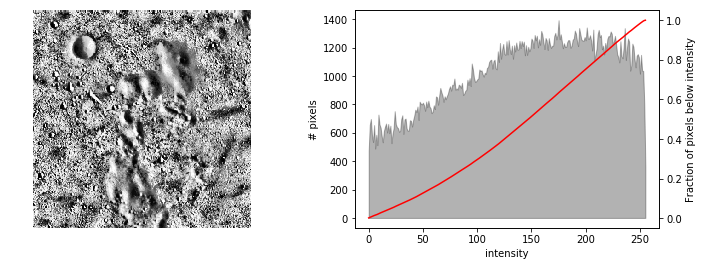

In [28]:
# Equalization
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank

selem = disk(30)
local_equalized = rank.equalize(image, selem=selem)

ax_image, ax_hist = skdemo.imshow_with_histogram(local_equalized)
skdemo.plot_cdf(local_equalized, ax=ax_hist.twinx())


## Contrasted-limited, Adaptive Histogram Equalization

Contrast-limited adaptive histogram equalization (CLAHE) addresses these issues. The implementation details aren't too important, but seeing the result is helpful:

In [29]:
equalized = exposure.equalize_adapthist(image)

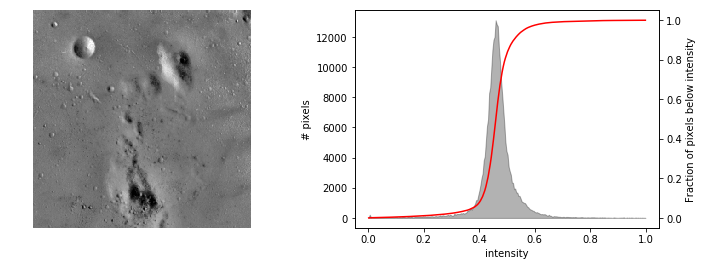

In [30]:
ax_image, ax_hist = skdemo.imshow_with_histogram(equalized)
skdemo.plot_cdf(equalized, ax=ax_hist.twinx())

Compared to plain-old histogram equalization, the high contrast in the coat is maintained, but the contrast in the grass is also improved. 
Furthermore, the contrast doesn't look overly-enhanced, as it did with the standard histogram equalization.

Again, notice that the output data-type is different than our input. This time, we have a `uint16` image, which is another common format for images:

In [31]:
equalized.dtype

dtype('float64')

There's a bit more tweaking involved in using `equalize_adapthist` than in `equalize_hist`: Input parameters are used to control the patch-size and contrast enhancement. You can learn more by checking out the docstring:

In [32]:
exposure.equalize_adapthist?

Signature: exposure.equalize_adapthist(image, kernel_size=None, clip_limit=0.01, nbins=256, **kwargs)
Docstring:
Contrast Limited Adaptive Histogram Equalization (CLAHE).

An algorithm for local contrast enhancement, that uses histograms computed
over different tile regions of the image. Local details can therefore be
enhanced even in regions that are darker or lighter than most of the image.

Parameters
----------
image : (M, N[, C]) ndarray
    Input image.
kernel_size: integer or list-like, optional
    Defines the shape of contextual regions used in the algorithm. If
    iterable is passed, it must have the same number of elements as
    ``image.ndim`` (without color channel). If integer, it is broadcasted
    to each `image` dimension. By default, ``kernel_size`` is 1/8 of
    ``image`` height by 1/8 of its width.
clip_limit : float, optional
    Clipping limit, normalized between 0 and 1 (higher values give more
    contrast).
nbins : int, optional
    Number of gray bins for his

Note that the features of the man's face are slightly better resolved in this case.

You can find a few other thresholding methods in the `filters` module: